# **Data Visualization**

## Objectives

* Fulfill Business Requirement 1 - The client is interested in determining the visual differences between normal breast ultrasounds, those containing benign tumours and those containing malignant tumours.

## Inputs

* inputs/breast_cancer_dataset/ultrasound_images/train
* inputs/breast_cancer_dataset/ultrasound_images/validation
* inputs/breast_cancer_dataset/ultrasound_images/test

## Outputs

* Scatterplot of image height and width.
* Image Shape embeddings in a pickle file.
* Standard Deviation and Mean of images per label.
* A plot to show image differences between the three classes.
* Code to present an plots and an image montage on the dashboard.


---

# Change working directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/breast-cancer-detection/jupyter_notebooks'

In [2]:
os.chdir("/workspace/breast-cancer-detection")
print("You set a new current directory.")

You set a new current directory.


In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/breast-cancer-detection'

### Set Input Directories

In [4]:
data_dir = "inputs/breast_cancer_dataset/ultrasound_images"
train_path = data_dir + "/train"
validation_path = data_dir + "/validation"
test_path = data_dir + "/test"

### Set Output Directory

In [5]:
version = "v1"
file_path = f"outputs/{version}"
if "outputs" in os.listdir(current_dir) and version in os.listdir(current_dir + "/outputs"):
    print("This directory exists, create a new version.")
else:
    os.makedirs(name=file_path)

### Set Label Names

In [6]:
labels = os.listdir(train_path)
print("The image labels are", labels)

The image labels are ['benign', 'malignant', 'normal']


---

# Data Visualization

### Image Shape

In [138]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread

def plot_height_width_images(save_image=False):
    """
    Function to plot the width and height of the images.
    """
    image_height, image_width = [], []
    for label in labels:
        for image_file in os.listdir(train_path + "/" + label):
            image = imread(train_path + "/" + label + "/" + image_file)
            height, width, color = image.shape
            image_height.append(height)
            image_width.append(width)
    sns.set_theme(style="darkgrid", palette="bright")
    fig, axes = plt.subplots()
    sns.scatterplot(x=image_width, y=image_height, alpha=0.5)
    axes.set_xlabel("Width (pixels)")
    axes.set_ylabel("Height (pixels)")
    axes.set_title("Height and Width of Ultrasound Images")
    height_mean = int(np.array(image_height).mean())
    width_mean = int(np.array(image_width).mean())
    if save_image:
        plt.savefig(f"{file_path}/height_width_plot.png")
    else:
        plt.show()
    print(f"The average image height is {height_mean} and the average image width is {width_mean}.")
    
    return height_mean, width_mean

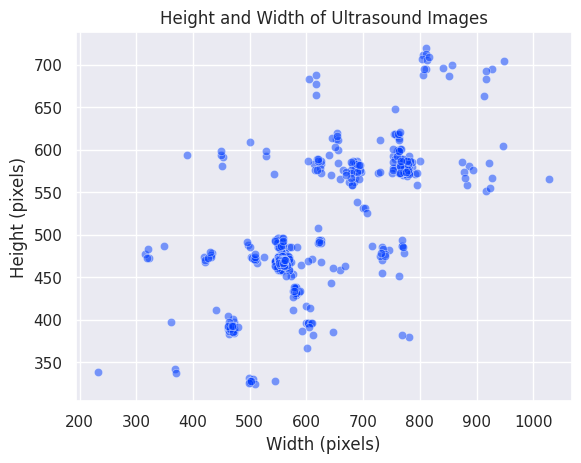

The average image height is 503 and the average image width is 615.


(503, 615, 1)

In [139]:
height_mean, width_mean = plot_height_width_images()
image_shape = (height_mean, width_mean, 1)
image_shape

In [24]:
joblib.dump(value=image_shape, filename=f"{file_path}/image_shape_embed.pkl")

['outputs/v1/image_shape_embed.pkl']

---

### Load Images as Array

In [89]:

from tensorflow.keras.preprocessing import image


def load_images_in_array(data_dir, new_size=(50, 50), n_images_per_label=20):
    """
    Function to load images in an array.
    """

    # Set X as an interger and y as an object
    X, y = np.array([], dtype="int"), np.array([], dtype="object")
    labels = os.listdir(data_dir)

    for label in labels:
        count = 0
        for image_file in os.listdir(data_dir + "/" + label):
            # Stop when count reaches this number to save time
            if count < n_images_per_label:
                file = image.load_img(data_dir + "/" + label + "/" + image_file, color_mode="grayscale", target_size=new_size)
                # Resize the image only if the max pixel value is above 1
                if image.img_to_array(file).max() > 1:
                    resized_image = image.img_to_array(file) / 255
                else:
                    resized_image = image.img_to_array(file)
                X = np.append(X, resized_image).reshape(-1, new_size[0], new_size[1], resized_image.shape[2])
                y = np.append(y, label)
                count += 1

    return X, y


In [95]:
X, y = load_images_in_array(data_dir=train_path, new_size=image_shape, n_images_per_label=15)
print(X.shape, y.shape)

(45, 503, 615, 1) (45,)


### Average Image and Image Variability

In [105]:
def plot_image_mean_and_variability_as_array(X, y, figsize=(10,5), save_image=False):
    """
    Function to loop through the labels, subset an array for each label
    and caclulate/plot the standard deviation and mean.
    """
    sns.set_style("white")
    for label in np.unique(y):
        # Subset an array
        y = y.reshape(-1,1,1)
        boolean_mask = np.any(y==label, axis=1).reshape(-1)
        array = X[boolean_mask]

        # Calculate the mean per label
        avg_image = np.mean(array, axis=0)
        # Calculate the variability per label
        std_image = np.std(array, axis=0)

        print(f"Label: {label}")
        print(f"Image shape: {avg_image.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average Image for {label}")
        axes[0].imshow(avg_image, cmap="gray")
        axes[1].set_title(f"Image Variability for {label}")
        axes[1].imshow(std_image, cmap="gray")
        if save_image:
            plt.savefig(f"{file_path}/mean_std_{label}.png")
        else:
            plt.show()
            
        print("\n")


Label: benign
Image shape: (503, 615, 1)


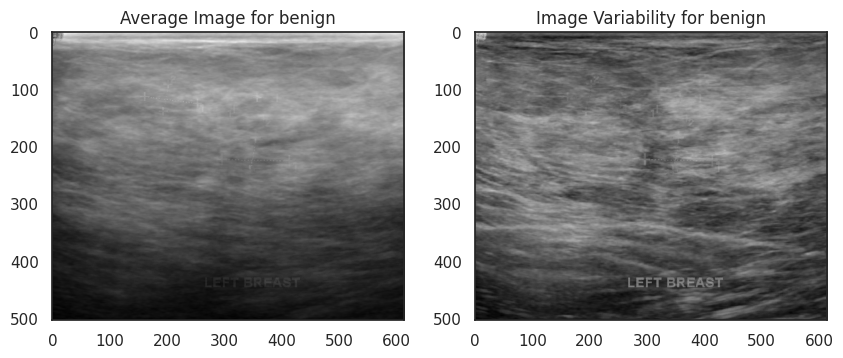



Label: malignant
Image shape: (503, 615, 1)


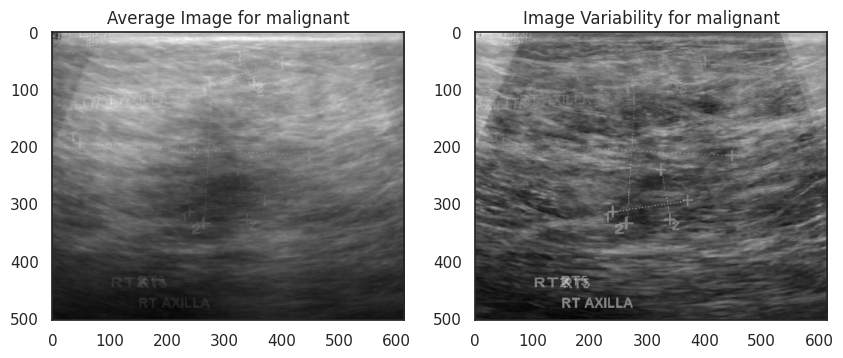



Label: normal
Image shape: (503, 615, 1)


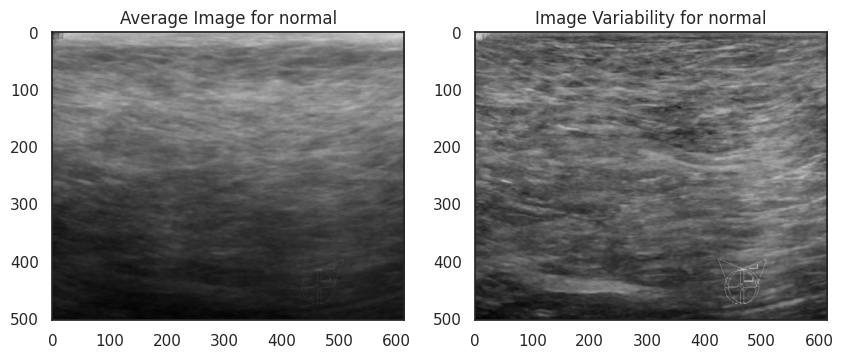

In [106]:
plot_image_mean_and_variability_as_array(X, y)

In [113]:
np.unique(y)

array(['benign', 'malignant', 'normal'], dtype=object)

### Differences between Benign, Malignant and Normal Ultrasound Images

In [136]:
def subset_image_label(X, y, label):
    """
    Function to subset the image per label
    """
    y = y.reshape(-1,1,1)
    boolean_mask = np.any(y==label, axis=1).reshape(-1)
    df_ultrasound = X[boolean_mask]
    return df_ultrasound

def differences_between_two_labels(X, y, label_1, label_2, figsize=(10,5), save_image=False):
    """
    Function to plot the average image and image differences between two labels.
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(f"Either {label_1} or {label_2} are not in {np_unique(y)}.")
        return
    
    # Calculate label 1 mean
    image_1 = subset_image_label(X, y, label_1)
    image_1_avg = np.mean(image_1, axis=0)

    # Calculate label 2 mean
    image_2 = subset_image_label(X, y, label_2)
    image_2_avg = np.mean(image_2, axis=0)

    differences = image_1_avg - image_2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    print("\n")
    axes[0].set_title(f"Average {label_1}")
    axes[0].imshow(image_1_avg, cmap="gray")
    axes[1].set_title(f"Average {label_2}")
    axes[1].imshow(image_2_avg, cmap="gray")
    axes[2].set_title(f"Differences: Average {label_1} and {label_2}")
    axes[2].imshow(differences, cmap="gray")
    if save_image:
        plt.savefig(f"{file_path}/variability_{label_1}_{label_2}.png", bbox_inches="tight", dpi=150)
    else:
        plt.tight_layout()
        plt.show()
        


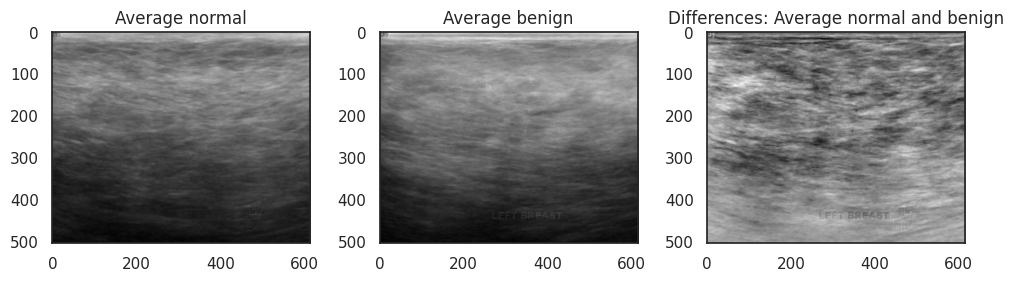

In [137]:
differences_between_two_labels(X, y, label_1="normal", label_2="benign")

### Image Montage

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
